# Function Fitting with Constraints

In some real world applications, learned models need to fulfill additional constraints. For example, in physics, simulations must obey energy conservation laws. When replacing the exact physics with learned models from data, we have to ensure that these laws hold, in order for the simulation not to diverge. In this exercise, we will consider integral constraints of the form

$q = \int_{0}^{1} f(x) dx$

that is, the learned function f must integrate to q over the integral $[0,1]$. Your task is to extend Gaussian Processes to integrate these integral constraints. As an example case, we will consider learning the function

$g(x) = -(sin(6 \pi x))^2 + 6x^2 - 5x^4 + 3/2$

on the interval $x \in [0,1]$ using the integral constraint $q = 2$.

## B.1 Fitting a standard GP

We will first consider the simpler problem of fitting a Gaussian Process without the additional constraint. This will form your baseline. You will first implement a standard GP model using the maximum a-posteriori estimate of hyper parameters and compare that to the sampled GP using NUTS.

As dataset, we assume that observations are given by:

$y_i = g(x_i) + \epsilon, \epsilon \sim \mathcal{N}(0,0.01)$ ,

where the observations are the grid $x_i = \frac{i-1}{l-1}, i = 1..., l$ with $l = 30$. Partition the set of points randomly into a set of 20 points for training and 10 for evaluation. Follow the steps below:

1. Select a suitable model with your own choice of kernel. Identify the parameters of the model and decide which parameters are fixed and which are variable (you need 2 or more variable parameters). We will refer to the variable parameters as $\theta$. For each parameter, pick a suitable prior distribution and implement the model (or use the GP implemented in Pyro) as well as a function implementing $log p(y,\theta|X)$.

2. Compute the maximum a-posteriori estimate $\theta^*$ (e.g., using grid search or gradient descent) and evaluate the posterior log-likelihood of the test set on the fitted GP using $\theta^*$.

3. Use NUTS to sample from the posterior. Check the quality of the MCMC sampling using diagnostics (Arviz). Use the diagnostics to choose the hyperparameters of the sampling (such as the number of warmup samples).

4. Compute the approximate posterior likelihood of the samples in the test set using 500 sampled values of $\theta$.

5. Repeat this procedure for 20 different generated datasets for both approaches and compare the obtained test likelihoods.

Deliverables:
 - A mathematical description of the chosen probabilistic model $p(\theta,y|X)$ and a reasoning behind the chosen kernels and priors.
- An analysis of your obtained sample quality for the models
- State the equation of the approximate posterior likelihood you implemented.
- Compare the likelihoods of the model using either MAP or approximate posterior likelihood and report mean and standard deviation. Can you argue whether one of your models performed better than the other?

Hint: If it appears that Pyro ignores your setting of a kernel parameter, consider cleaning up old variables with pyro.clear param store().

In [1]:
import torch 
from torch.optim import Adam

import cloudpickle
import pyro

from pyro.contrib.gp.kernels import RBF, Periodic, Kernel
from pyro.contrib.gp.models import GPRegression
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.svi import SVI
import pyro.distributions as dist
from pyro import poutine

#from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

pyro.clear_param_store()

## ------------------------ Step 1----------------------------------

In [2]:
# Generate the data based of function g(x)
def generate_data(n_points = 30, noise_std = 0.1):
    x = torch.linspace(0,1, n_points).unsqueeze(-1)
    g = lambda x: -(torch.sin(6*torch.pi*x)**2) + 6 * x**2 - 5 * x**4 + 1.5
    y_true = g(x)
    epsilon = torch.normal(mean=0.0, std=noise_std, size=y_true.shape)
    y_obs = y_true + epsilon
    
    return x, y_obs, y_true

In [3]:
# Define the kernels combining a Gaussian and a periodic kernel  
class CombinedKernel(Kernel):
    def __init__(self, input_dim, ls_rbf, var_rbf, ls_periodic, var_periodic, period):
        '''
        ls_rbf: lenghtscale of the Gaussian kernel
        var_rbf: variance of the Gaussian kernel
        ls_periodic: lenghtscale of the Periodic kernel
        var_periodic: variance of the Periodic kernel
        period: period of the periodic kernel
        '''
        super().__init__(input_dim)
        self.kernel_rbf = RBF(input_dim, variance=var_rbf, lengthscale=ls_rbf)
        self.kernel_periodic = Periodic(input_dim, variance=var_periodic, lengthscale=ls_periodic, period=period)
    
    def forward(self, X1, X2):
        # Combine the Gaussian and Periodic kernels
        return self.kernel_rbf.forward(X1, X2) + self.kernel_periodic.forward(X1, X2)
        
# Initialize the combined kernel
ls_rbf = pyro.param("ls_rbf", torch.tensor(0.2), constraint=dist.constraints.positive)
var_rbf = pyro.param("var_rbf", torch.tensor(1.0), constraint=dist.constraints.positive)
ls_periodic = pyro.param("ls_periodic", torch.tensor(0.1), constraint=dist.constraints.positive)
var_periodic = pyro.param("var_periodic", torch.tensor(0.5), constraint=dist.constraints.positive)
period = torch.tensor(1 / 6)  # Fixed period
input_dim = 1

#Generate the data
x, y_obs, y_true = generate_data()
x_train, x_test = x[:20], x[20:]
y_train, y_test = y_obs[:20].squeeze(-1), y_obs[20:].squeeze(-1)

print(x_train.shape)
print(y_train.shape)

kernel = CombinedKernel(input_dim, ls_rbf, var_rbf, ls_periodic, var_periodic, period)

# Create the GP model
gp_model = GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.1))
gp_model.mean_function = lambda x: torch.zeros(x.shape[0])

# log probability computation
def log_joint(y_obs, x):
    '''
    Compute log p(y, θ | X) = log p(y | X, θ) + log p(θ)
    '''
    kernel_matrix = kernel.forward(x, x) + torch.eye(len(x)) * gp_model.noise
    log_likelihood = dist.MultivariateNormal(loc=gp_model.mean_function(x), covariance_matrix=kernel_matrix).log_prob(y_obs)
    
    # Priors (log p(θ))
    log_prior = (
        dist.Gamma(2.0, 1.0).log_prob(ls_rbf) +
        dist.LogNormal(0.0, 1.0).log_prob(var_rbf) +
        dist.Gamma(2.0, 2.0).log_prob(ls_periodic) +
        dist.LogNormal(0.0, 1.0).log_prob(var_periodic)
    )
    
    return log_likelihood + log_prior

log_joint_value = log_joint(y_train, x_train)
print(f"Log joint probability: {log_joint_value.item()}")

torch.Size([20, 1])
torch.Size([20])
Log joint probability: -26.962604522705078


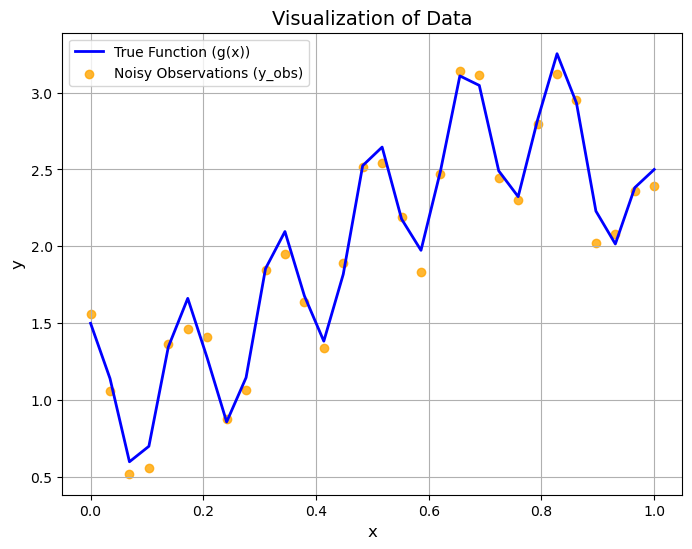

In [4]:
# Plot the data
def plot_data(x, y_obs, y_true):
    plt.figure(figsize=(8, 6))
    
    # Plot the true function
    plt.plot(x.squeeze(), y_true.squeeze(), label="True Function (g(x))", color="blue", linewidth=2)
    
    # Plot the noisy observations
    plt.scatter(x.squeeze(), y_obs.squeeze(), label="Noisy Observations (y_obs)", color="orange", alpha=0.8)
    
    plt.title("Visualization of Data", fontsize=14)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the data
plot_data(x, y_obs, y_true)

## ------------------------ Step 2 ----------------------------------

In [5]:
# Define the loss function using log_joint
def loss_fn():
    return -log_joint(y_train, x_train)  # Negative log joint

# Set up PyTorch's Adam optimizer
ls_rbf = torch.tensor(0.2, requires_grad=True)
var_rbf = torch.tensor(1.0, requires_grad=True)
ls_periodic = torch.tensor(0.1, requires_grad=True)
var_periodic = torch.tensor(0.5, requires_grad=True)

params = [ls_rbf, var_rbf, ls_periodic, var_periodic]  # Parameters to optimize
optimizer = Adam(params, lr=0.01)  # Learning rate

# Training loop
num_iterations = 500
for i in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients
    loss = loss_fn()  # Compute the loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    if i % 50 == 0:
        print(f"Iteration {i} - Loss: {loss.item()}")

# Compute log posterior likelihood on the test set
def test_log_likelihood():
    kernel_matrix = kernel.forward(x_test, x_test) + torch.eye(len(x_test)) * gp_model.noise
    log_likelihood = dist.MultivariateNormal(
        loc=gp_model.mean_function(x_test), covariance_matrix=kernel_matrix
    ).log_prob(y_test)
    return log_likelihood

log_likelihood_test = test_log_likelihood()
print(f"Log posterior likelihood on test set: {log_likelihood_test.item()}")

print(f"Optimized RBF Lengthscale (ls_rbf): {ls_rbf.item()}")
print(f"Optimized RBF Variance (var_rbf): {var_rbf.item()}")
print(f"Optimized Periodic Lengthscale (ls_periodic): {ls_periodic.item()}")
print(f"Optimized Periodic Variance (var_periodic): {var_periodic.item()}")


Iteration 0 - Loss: 26.962604522705078
Iteration 50 - Loss: 24.99728012084961
Iteration 100 - Loss: 24.831029891967773
Iteration 150 - Loss: 24.80620574951172
Iteration 200 - Loss: 24.799224853515625
Iteration 250 - Loss: 24.797279357910156
Iteration 300 - Loss: 24.796783447265625
Iteration 350 - Loss: 24.796672821044922
Iteration 400 - Loss: 24.79665184020996
Iteration 450 - Loss: 24.796648025512695
Log posterior likelihood on test set: -13.64734935760498
Optimized RBF Lengthscale (ls_rbf): 0.999664843082428
Optimized RBF Variance (var_rbf): 0.3678794801235199
Optimized Periodic Lengthscale (ls_periodic): 0.5000001192092896
Optimized Periodic Variance (var_periodic): 0.3678794503211975


## ------------------------ Step 3 ----------------------------------

In [ ]:
pyro.clear_param_store()

In [6]:
# Define the probabilistic model for NUTS
def model():
    '''
    The model function defines the posterior distribution for the kernel parameters by combining:
    1. priors for parameters: plausible ranges that also ensure they remain positive
    2. Kernel construction: CombinedKernel using the sampled paraneters. 
    3. The likekihood term: modeled as a multilivate normal distribution 
    '''
    # Priors
    ls_rbf = pyro.sample("ls_rbf", dist.Gamma(2.0, 1.0))
    var_rbf = pyro.sample("var_rbf", dist.LogNormal(0.0, 1.0))
    ls_periodic = pyro.sample("ls_periodic", dist.Gamma(2.0, 2.0))
    var_periodic = pyro.sample("var_periodic", dist.LogNormal(0.0, 1.0))
    
    # Kernel with sampled parameters
    kernel = CombinedKernel(input_dim = 1, 
                            ls_rbf = ls_rbf, 
                            var_rbf = var_rbf, 
                            ls_periodic = ls_periodic, 
                            var_periodic = var_periodic, 
                            period = torch.tensor(1 / 6))
    
    # GP model likelihood
    kernel_matrix = kernel.forward(x_train, x_train) + torch.eye(len(x_train)) * gp_model.noise
    pyro.sample("y_train", dist.MultivariateNormal(loc=gp_model.mean_function(x_train), 
                                                   covariance_matrix=kernel_matrix), obs=y_train)
'''
# Set up NUTS sampler
nuts_kernel = NUTS(model = model, step_size = 1)

mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=50, num_chains=1)
mcmc.run()

# Posterior samples
posterior_samples = mcmc.get_samples()

# inspect visually
print(mcmc.summary())

az_data = az.from_pyro(mcmc, log_likelihood=False)
az.plot_trace(az_data)
plt.show()
az.plot_posterior(az_data)
plt.show()

nuts_summary = az.summary(az_data)
print(nuts_summary)
'''

'\n# Set up NUTS sampler\nnuts_kernel = NUTS(model = model, step_size = 1)\n\nmcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=50, num_chains=1)\nmcmc.run()\n\n# Posterior samples\nposterior_samples = mcmc.get_samples()\n\n# inspect visually\nprint(mcmc.summary())\n\naz_data = az.from_pyro(mcmc, log_likelihood=False)\naz.plot_trace(az_data)\nplt.show()\naz.plot_posterior(az_data)\nplt.show()\n\nnuts_summary = az.summary(az_data)\nprint(nuts_summary)\n'

Sample: 100%|██████████████████████████████████████████| 600/600 [08:13,  1.22it/s, step size=3.28e-03, acc. prob=0.465]                             
/Users/javiilaing/anaconda3/lib/python3.11/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   ls_periodic      1.79      0.64      1.77      0.79      2.96     63.53      1.02
        ls_rbf      0.97      0.56      0.83      0.27      1.71     69.43      1.00
  var_periodic      0.77      0.53      0.65      0.09      1.45     55.42      1.00
       var_rbf      3.52      2.94      2.83      0.22      7.00     80.73      1.01

Number of divergences: 0
None


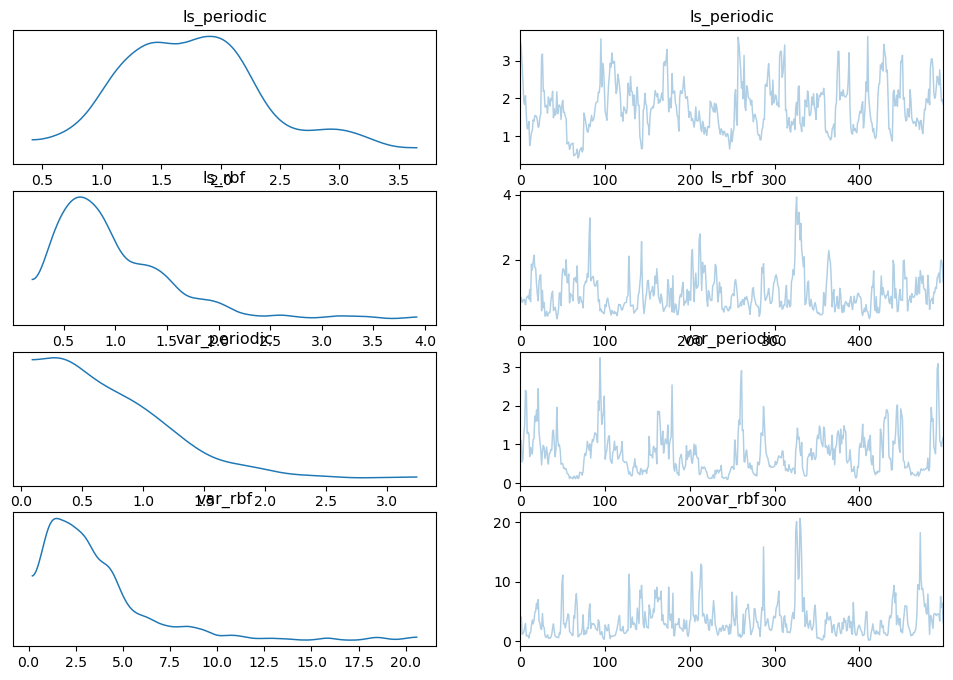

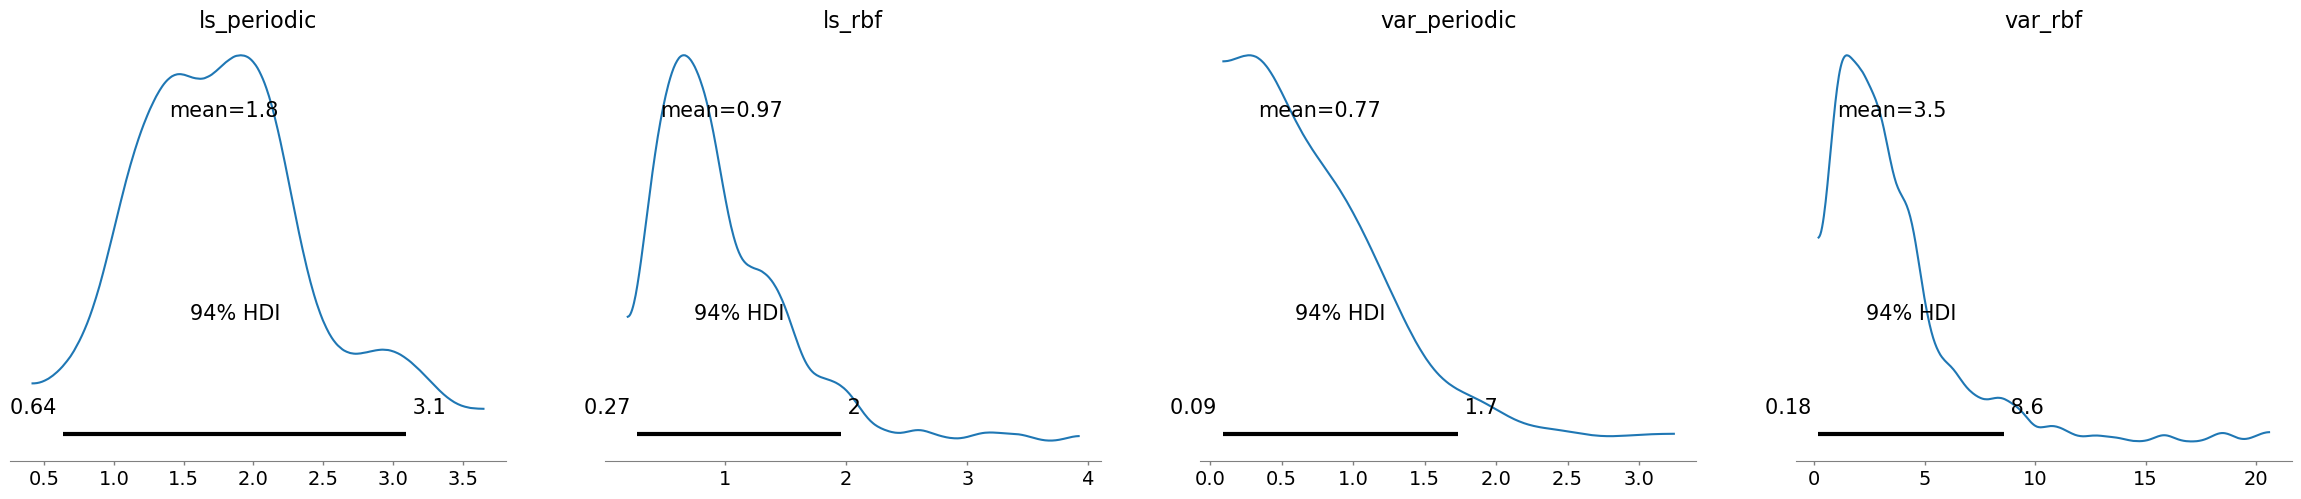

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ls_periodic   1.788  0.638   0.637    3.095      0.082    0.058      55.0   
ls_rbf        0.972  0.556   0.273    1.961      0.066    0.047      68.0   
var_periodic  0.766  0.533   0.090    1.735      0.072    0.052      41.0   
var_rbf       3.522  2.936   0.179    8.578      0.334    0.237      63.0   

              ess_tail  r_hat  
ls_periodic       31.0    NaN  
ls_rbf            95.0    NaN  
var_periodic      22.0    NaN  
var_rbf           96.0    NaN  


In [7]:
# Set up NUTS sampler
nuts_kernel = NUTS(model = model)

mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run()

# Posterior samples
posterior_samples = mcmc.get_samples()

# inspect visually
print(mcmc.summary())

az_data = az.from_pyro(mcmc)
az.plot_trace(az_data)
plt.show()
az.plot_posterior(az_data)
plt.show()

nuts_summary = az.summary(az_data)
print(nuts_summary)

## ------------------------ Step 4 ----------------------------------

In [ ]:
def compute_posterior_likelihood(posterior_samples, x_test, y_test):
    '''
    Compute the approximate posterior likelihood for the test set using 500 samples.
    
    Args:
        posterior_samples: Dictionary of sampled parameter values.
        x_test: Test set input features.
        y_test: Test set observed values.
    
    Returns:
        Approximate posterior likelihood.
    '''
    log_likelihoods = []
    
    # Use the first 500 posterior samples
    for i in range(500):
        # Extract sampled parameters for this iteration
        sampled_ls_rbf = posterior_samples["ls_rbf"][i].detach()
        sampled_var_rbf = posterior_samples["var_rbf"][i].detach()
        sampled_ls_periodic = posterior_samples["ls_periodic"][i].detach()
        sampled_var_periodic = posterior_samples["var_periodic"][i].detach()
        
        # Recreate the kernel for this sample
        kernel = CombinedKernel(
            input_dim=1,
            ls_rbf=sampled_ls_rbf,
            var_rbf=sampled_var_rbf,
            ls_periodic=sampled_ls_periodic,
            var_periodic=sampled_var_periodic,
            period=torch.tensor(1 / 6)
        )
        
        # Compute the kernel matrix for the test set
        kernel_matrix = kernel.forward(x_test, x_test) + torch.eye(len(x_test)) * gp_model.noise
        
        # Compute the mean and covariance for the test set
        mean_test = gp_model.mean_function(x_test)  # Zero mean in this case
        covariance_test = kernel_matrix
        
        # Compute the log likelihood of y_test given this sample
        log_likelihood = dist.MultivariateNormal(
            loc=mean_test,
            covariance_matrix=covariance_test
        ).log_prob(y_test)
        log_likelihoods.append(log_likelihood.item())
    
    # Compute the average log likelihood across all samples
    return torch.tensor(log_likelihoods).mean().item()


# Call the function
approx_posterior_likelihood = compute_posterior_likelihood(posterior_samples, x_test, y_test)
print(f"Approximate posterior likelihood on test set: {approx_posterior_likelihood}")

## ------------------------ Step 5----------------------------------

Can be found in a separate python file: ExerciseB15.py

Learning with Integral Constraints. We will now extend the previous approach to include an integral constraint. Since exact integration is infeasible, we will instead approximate it using Trapezoidal rule
that is computed on a grid of points $X$ with elements $xi = \frac{i−1}{l-1}$, $i = 1,...,l$ as 


$q \approx \hat{q} = \sum^{l}_{i=1} w_i f(x_i)$, 

$$
w_i =
\begin{cases} 
\frac{1}{2l-2}, & \text{for } i \in \{1, l\} \\ 
\frac{1}{l-1}, & \text{otherwise} 
\end{cases}
$$

To model $f$, we will assume the GP prior $f \sim GP(0,k(·,·))$, where $k$ is the kernel with parameters from the MAP estimate from part 1. Follow the derivation steps:

1. Derive the probability distribution of the random variable $(\hat{q}, f)|X $ and show that it is normal distributed. Hint: Write the vector $(\hat{q}, f)$ as a linear transformation of $f$ and use properties of the multivariate normal distribution. You can use the weight vector $w$ to simplify the result.
2. Derive the probability distribution of the random variable $f|X,\hat{q}$. Assuming $k$ is a universal kernel, does the covariance matrix of this distribution have full rank?

3. Plot five samples from $f|X,\hat{q}$ for $l = 101$ and different choices for $\hat{q} \in {0,5,10}$

4. Consider that you obtain a dataset $D$ with three input-label pairs $(x_i,y_i)$ following $y_i = g(x_i) + \epsilon, \epsilon \sim N(0,0.01)$. The exact dataset is: $ D = {(0,1.46),(0.25,0.93),(0.5,2.76)}$ Compute the posteriors $f|\hat{q},D$ and $f|D$ (i.e., the GP prediction with and without constraint after observing $D$) and visualize the distribution. As parameters, use $l = 101$ and $\hat{q} = 2$.

Hints: derive your models using the rules for the normal distribution. The Pyro GP class is not easy to use here. For sampling, you can use the eigenvalue decomposition to obtain a decomposition $\Sigma = AA^T$ of the covariance matrix.

Deliverables:
- Derivations and resulting mean and covariance matrix for $(\hat{q},f)|X$ and $f|X,\hat{q}$.

- Discussion on whether the covariance matrix of the distribution $f|X,\hat{q}$ has full rank.

- Three plots visualizing the samples from $f|X,\hat{q}$. Compare the different results and discuss their differences.

- Two plots visualizing the posteriors $f|\hat{q},D$ and $f|D$. For this, overlay a plot of $g(x)$, a scatter plot of $D$, and plots of $m(X)$ as well as $m(X) \pm 1.95 /sqrt{v(X)}$, where $m$ and $v$ are the vectors of means and variances of the random variables at the locations $x_i, i = 1,...,l$ of the GP posterior, respectively. Compare the plots and discuss your observations.

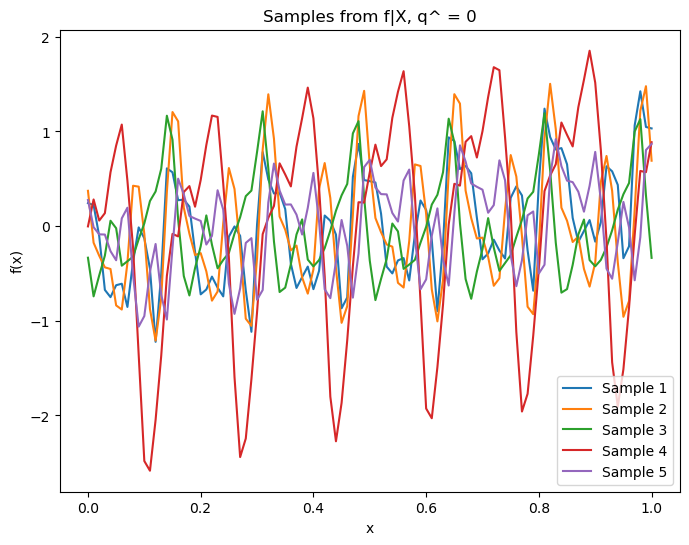

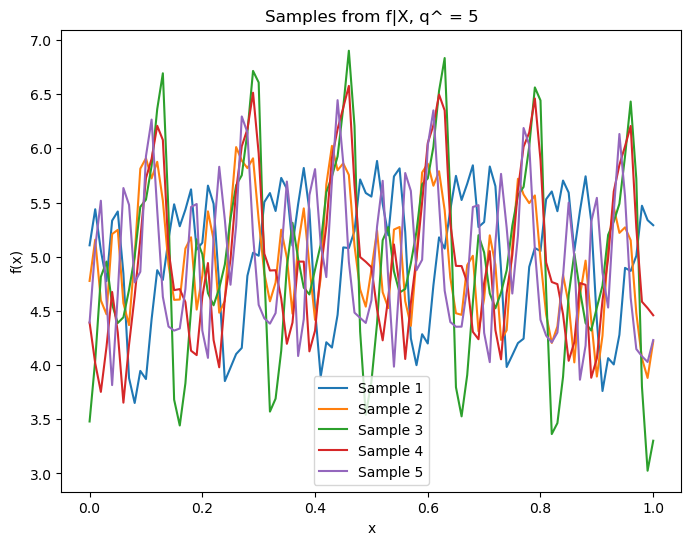

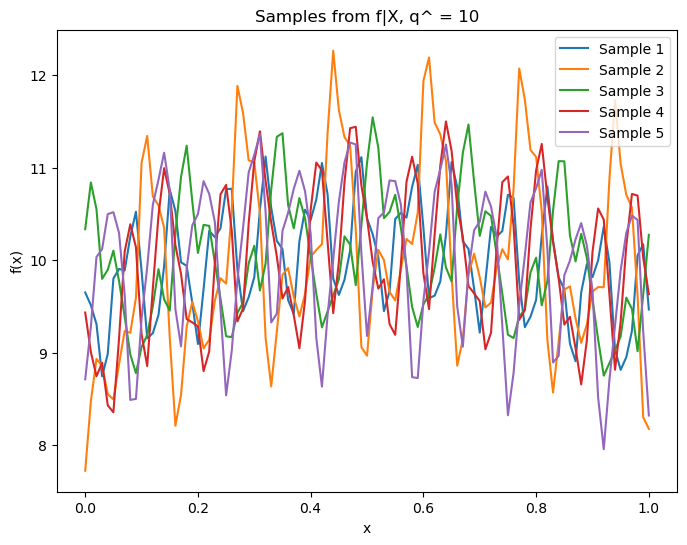

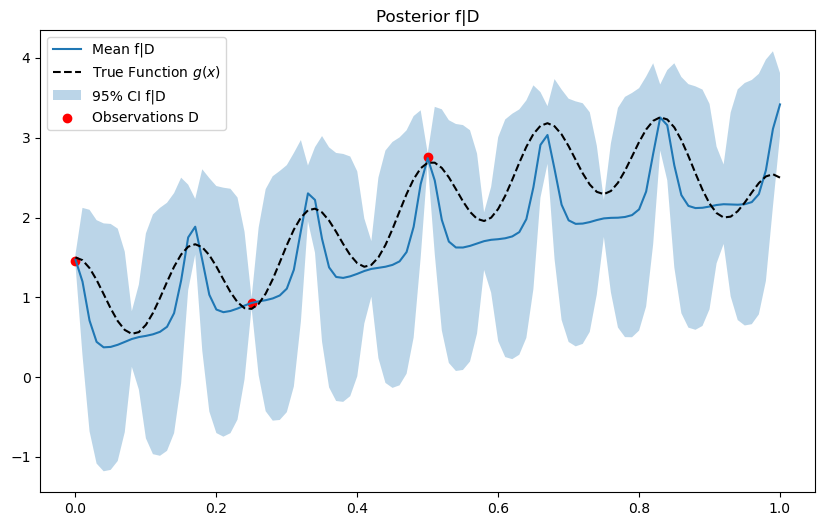

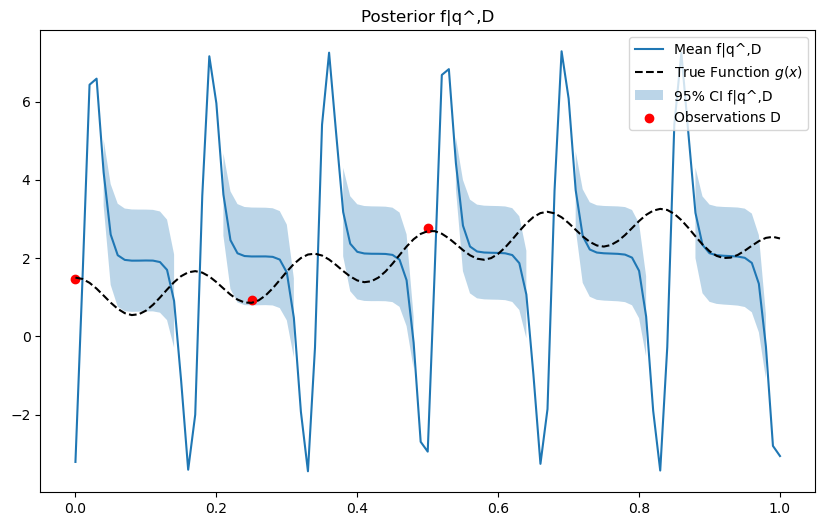

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the combined kernel from Part 1
class CombinedKernel:
    def __init__(self, input_dim, ls_rbf, var_rbf, ls_periodic, var_periodic, period):
        self.kernel_rbf = RBF(input_dim=input_dim, variance=var_rbf, lengthscale=ls_rbf)
        self.kernel_periodic = Periodic(
            input_dim=input_dim, variance=var_periodic, lengthscale=ls_periodic, period=period
        )
    
    def forward(self, X1, X2):
        return self.kernel_rbf.forward(X1, X2) + self.kernel_periodic.forward(X1, X2)

# Step 1: Compute the joint distribution of (q^, f)|X
def compute_joint_distribution(kernel, X, w):
    # Compute covariance matrix K
    K = kernel.forward(X, X)

    # Compute weights and joint covariance
    wT_K_w = torch.dot(w, K @ w)  # Scalar
    wT_K = K @ w                  # Vector
    joint_covariance = torch.cat([
        torch.cat([wT_K_w.unsqueeze(0).unsqueeze(0), wT_K.unsqueeze(0)], dim=1),
        torch.cat([wT_K.unsqueeze(1), K], dim=1)
    ], dim=0)

    return joint_covariance

# Step 2: Compute conditional distribution f|X,q^
def compute_conditional_distribution(X, w, q_value, kernel):
    K = kernel.forward(X, X)  # Covariance matrix
    wT_K_w = torch.dot(w, K @ w)  # Scalar
    wT_K = K @ w  # Vector

    # Compute conditional mean and covariance
    Sigma_fq = K @ w
    Sigma_qq_inv = 1 / wT_K_w  # Inverse of scalar
    mu_f = Sigma_fq * Sigma_qq_inv * q_value
    Sigma_f = K - torch.outer(Sigma_fq, Sigma_fq) * Sigma_qq_inv

    return mu_f, Sigma_f

# Step 3: Plot samples from f|X, q^
def plot_samples(X, kernel, q_values, num_samples=5):
    l = len(X)
    # Create trapezoidal weights
    w = torch.cat([torch.tensor([1 / (2 * (l - 1))]), 
                   torch.full((l - 2,), 1 / (l - 1)), 
                   torch.tensor([1 / (2 * (l - 1))])])

    for q in q_values:
        mu_f, Sigma_f = compute_conditional_distribution(X, w, q, kernel)

        # Eigenvalue decomposition
        eigenvalues, eigenvectors = torch.linalg.eigh(Sigma_f + 1e-5 * torch.eye(len(Sigma_f)))
        sqrt_eigenvalues = torch.sqrt(torch.clamp(eigenvalues, min=0))  # Ensure non-negative
        L = eigenvectors @ torch.diag(sqrt_eigenvalues)

        # Generate samples
        samples = mu_f.unsqueeze(-1) + L @ torch.randn((len(X), num_samples))

        # Plot the samples
        plt.figure(figsize=(8, 6))
        for i in range(num_samples):
            plt.plot(X.detach().numpy(), samples[:, i].detach().numpy(), label=f"Sample {i+1}")
        plt.title(f"Samples from f|X, q^ = {q}")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.show()



# Step 4: Compute and visualize posteriors f|q^, D and f|D
def posterior_with_and_without_constraint(X, kernel, D, q_value):
    l = len(X)
    w = torch.cat([torch.tensor([1 / (2 * (l - 1))]), 
                   torch.full((l - 2,), 1 / (l - 1)), 
                   torch.tensor([1 / (2 * (l - 1))])])
    X_D = torch.tensor([d[0] for d in D])
    Y_D = torch.tensor([d[1] for d in D])

    # Compute f|D
    K = kernel.forward(X, X)
    K_D = kernel.forward(X, X_D)
    K_DD = kernel.forward(X_D, X_D) + 1e-3 * torch.eye(len(X_D))
    K_DD_inv = torch.linalg.inv(K_DD)
    
    mu_f_D = K_D @ K_DD_inv @ Y_D
    Sigma_f_D = K - K_D @ K_DD_inv @ K_D.T

    # Compute f|q^, D
    mu_f_q, Sigma_f_q = compute_conditional_distribution(X, w, q_value, kernel)
    Sigma_fq_D = Sigma_f_q[:len(X), :len(X_D)]
    mu_f_qD = mu_f_q + Sigma_fq_D @ K_DD_inv @ (Y_D - mu_f_q[:len(X_D)])
    Sigma_f_qD = Sigma_f_q - Sigma_fq_D @ K_DD_inv @ Sigma_fq_D.T
    
    # Define the true function g(x)
    g = lambda x: -(torch.sin(6 * torch.pi * x)**2) + 6 * x**2 - 5 * x**4 + 1.5
    g_true = g(X)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(X.detach().numpy(), mu_f_D.detach().numpy(), label="Mean f|D")
    plt.plot(X.detach().numpy(), g_true.detach().numpy(), label="True Function $g(x)$", color="black", linestyle="--")
    plt.fill_between(X.detach().numpy().squeeze(),
                     (mu_f_D - 1.95 * torch.sqrt(torch.diag(Sigma_f_D))).detach().numpy(),
                     (mu_f_D + 1.95 * torch.sqrt(torch.diag(Sigma_f_D))).detach().numpy(),
                     alpha=0.3, label="95% CI f|D")
    plt.scatter(X_D.detach().numpy(), Y_D.detach().numpy(), c="red", label="Observations D")
    plt.title("Posterior f|D")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(X.detach().numpy(), mu_f_qD.detach().numpy(), label="Mean f|q^,D")
    plt.plot(X.detach().numpy(), g_true.detach().numpy(), label="True Function $g(x)$", color="black", linestyle="--")
    plt.fill_between(X.detach().numpy().squeeze(),
                     (mu_f_qD - 1.95 * torch.sqrt(torch.diag(Sigma_f_qD))).detach().numpy(),
                     (mu_f_qD + 1.95 * torch.sqrt(torch.diag(Sigma_f_qD))).detach().numpy(),
                     alpha=0.3, label="95% CI f|q^,D")
    plt.scatter(X_D.detach().numpy(), Y_D.detach().numpy(), c="red", label="Observations D")
    plt.title("Posterior f|q^,D")
    plt.legend()
    plt.show()
    
X = torch.linspace(0, 1, 101).unsqueeze(-1)  # Grid of points

kernel = CombinedKernel(
    input_dim=1,
    ls_rbf=torch.tensor(0.999664843082428),  # Optimized RBF Lengthscale
    var_rbf=torch.tensor(0.3678794801235199),  # Optimized RBF Variance
    ls_periodic=torch.tensor(0.5000001192092896),  # Optimized Periodic Lengthscale
    var_periodic=torch.tensor(0.5000001192092896),  # Optimized Periodic Variance
    period=torch.tensor(1/6)  # Fixed period (unchanged from Part 1)
)


# Step 3: Plot samples for q^ = {0, 5, 10}
plot_samples(X, kernel, q_values=[0, 5, 10])

# Step 4: Posterior with and without constraint
D = [(0, 1.46), (0.25, 0.93), (0.5, 2.76)]
posterior_with_and_without_constraint(X, kernel, D, q_value=2)
  